# Graph reconstruction in 3d 

In 3d there is no implemented filtered Back projection, hence we accomodate it 
by structuring the ECT to make the FBP easier. 
 


In [1]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import numpy as np
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import torchvision.transforms.functional as f


def cartesion_to_spherical(xyz):
    ptsnew = np.zeros(xyz.shape)
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,0] = np.sqrt(xy + xyz[:,2]**2)
    ptsnew[:,1] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,2] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew

np.random.seed(42)

NUM_STEPS=256
NUM_PTS = 10

def generate_thetas():
    v = []
    for theta in torch.linspace(0,torch.pi,8):
        for phi in torch.linspace(0,torch.pi,64):
            v.append(
                torch.tensor([
                    torch.sin(phi)*torch.cos(theta),
                    torch.sin(phi)*torch.sin(theta),
                    torch.cos(phi)
                ])
                )
    return torch.vstack(v).T

# V = (torch.rand(size=(NUM_STEPS,3)) - 0.5)
# V /= V.pow(2).sum(axis=1).sqrt().unsqueeze(1)

# v = V.T

v = generate_thetas()


In [2]:
scale = 450
def compute_ect(x, v, ei=None):
    nh = x @ v
    lin = torch.linspace(-1, 1, NUM_STEPS).view(-1, 1, 1)
    ecc =  torch.nn.functional.sigmoid(scale * torch.sub(lin, nh))*(1- torch.nn.functional.sigmoid(scale * torch.sub(lin, nh)))
    ecc = ecc.sum(axis=1)
    if ei is not None:
        eh = nh[ei].mean(axis=0)
        eccedge = torch.nn.functional.sigmoid(scale * torch.sub(lin, eh))*(1- torch.nn.functional.sigmoid(scale * torch.sub(lin, eh)))
        eccedge = eccedge.sum(axis=1)
        ecc -= eccedge
    return ecc


x = torch.tensor([
    [0,0,0.0],
    [0,-.7,0.0],
    [.5,.5,0.0],
])


# x = torch.vstack(
#     [
#        .6 * torch.sin(
#             torch.tensor(
#                 np.linspace(0, torch.pi * 2, NUM_PTS, endpoint=False),
#                 dtype=torch.float32,
#             )
#         ),
#         .3 * torch.cos(
#             torch.tensor(
#                 np.linspace(0, torch.pi * 2, NUM_PTS, endpoint=False),
#                 dtype=torch.float32,
#             )
#         ),
#         torch.zeros_like(torch.linspace(0, torch.pi * 2, NUM_PTS))
#     ]
#     ).T

x = torch.tensor(np.random.uniform(-.7,.7,size=(NUM_PTS,3)),dtype=torch.float)
from torch_geometric.utils import erdos_renyi_graph
ei = erdos_renyi_graph(NUM_PTS,.1)
# ei = torch.vstack([torch.zeros(NUM_PTS-1,dtype=torch.long),torch.arange(1,NUM_PTS,dtype=torch.long)])
# ei = torch.tensor([[0, 1, 2],
#                    [1, 2, 0]])

In [3]:
ei

tensor([[1, 1, 2, 2, 4, 4, 4, 5, 7, 8, 8, 8],
        [4, 8, 4, 5, 1, 2, 8, 2, 8, 1, 4, 7]])

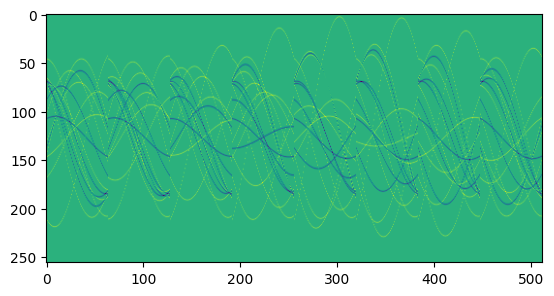

In [4]:
ect = compute_ect(x,v,ei=ei)

ect.shape
plt.imshow(ect)

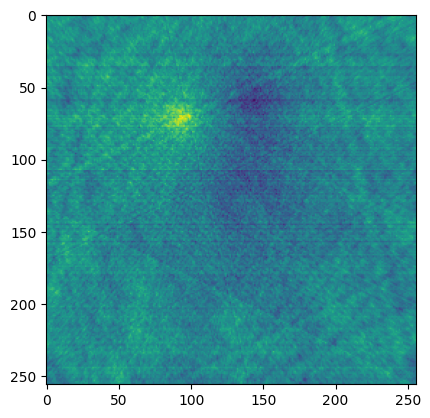

In [5]:
# ####################################################
# ### Reconstruct 3d using filtered backprojection.
# ####################################################

xg, yg ,zg = np.meshgrid(np.linspace(-1,1,NUM_STEPS,endpoint=False),np.linspace(-1,1,NUM_STEPS,endpoint=False),np.linspace(-1,1,NUM_STEPS,endpoint=False), indexing='ij', sparse=True)

recon = torch.zeros(NUM_STEPS,NUM_STEPS,NUM_STEPS)

def calc_idx(theta,xg,yg,zg):
    heights = theta[0]*xg + theta[1]*yg + theta[2]*zg
    idx=((heights + 1)  * NUM_STEPS/2).long()+1
    idx[idx>NUM_STEPS-1]=NUM_STEPS-1
    return idx

i = 0
for theta,slice in zip(v.T,ect.T):
    i +=1    
    idx = calc_idx(theta,xg,yg,zg)
    reps = slice[idx]
    recon += reps
    # if i==3:
    #     recon += reps
    #     break



plt.imshow(recon[:,:,int(NUM_STEPS/2)])

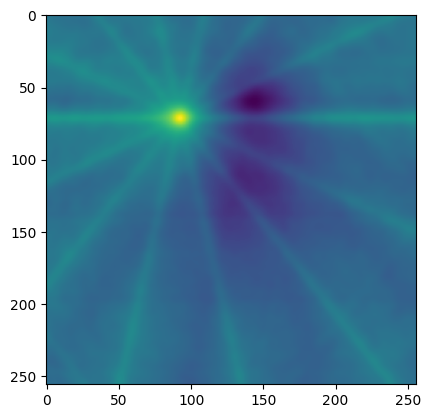

In [6]:
from scipy.ndimage import gaussian_filter

recon_f = gaussian_filter(recon,sigma=2)

plt.imshow(recon_f[:,:,128])

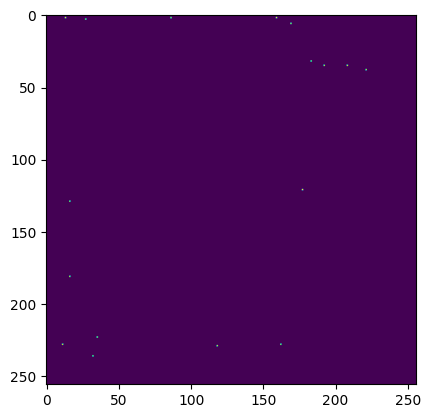

In [7]:
from scipy.ndimage import maximum_filter,minimum_filter
recon_np = recon.numpy()
res = maximum_filter(recon_np,footprint=np.ones((11,11,11)))
mask = (recon_np == res)
plt.imshow(mask[:,:,100])

In [8]:
idxx,idxy,idxz = np.nonzero(mask)
vals = recon[idxx,idxy,idxz]

vals /=vals.max()

idx = np.where(vals>.5)

idx_x = idxx[idx]
idx_y = idxy[idx]
idx_z = idxz[idx]

lin = np.linspace(-1,1,NUM_STEPS,endpoint=False)


pts = torch.tensor( np.vstack([lin[idx_x],
lin[idx_y],
lin[idx_z]]).T)

print(pts)
print(x)



sorted(vals)

tensor([[-0.6094,  0.5000,  0.1406],
        [-0.5000, -0.3047, -0.1875],
        [-0.4453, -0.2812,  0.0391],
        [-0.1719,  0.6172,  0.3281],
        [-0.0938, -0.3047,  0.1562],
        [-0.0625,  0.3828, -0.4141],
        [ 0.0156,  0.1172, -0.6328],
        [ 0.1406, -0.4922, -0.4844],
        [ 0.2891, -0.6797,  0.6562],
        [ 0.4609, -0.4141, -0.4375]], dtype=torch.float64)
tensor([[-0.1756,  0.6310,  0.3248],
        [ 0.1381, -0.4816, -0.4816],
        [-0.6187,  0.5126,  0.1416],
        [ 0.2913, -0.6712,  0.6579],
        [ 0.4654, -0.4027, -0.4454],
        [-0.4432, -0.2741,  0.0347],
        [-0.0953, -0.2923,  0.1566],
        [-0.5047, -0.2910, -0.1871],
        [-0.0615,  0.3992, -0.4205],
        [ 0.0199,  0.1294, -0.6350]])


[tensor(-0.1605),
 tensor(-0.1439),
 tensor(-0.1330),
 tensor(-0.1281),
 tensor(-0.1266),
 tensor(-0.1226),
 tensor(-0.1142),
 tensor(-0.1100),
 tensor(-0.1063),
 tensor(-0.1026),
 tensor(-0.1019),
 tensor(-0.1008),
 tensor(-0.1007),
 tensor(-0.0981),
 tensor(-0.0962),
 tensor(-0.0950),
 tensor(-0.0925),
 tensor(-0.0872),
 tensor(-0.0860),
 tensor(-0.0854),
 tensor(-0.0828),
 tensor(-0.0796),
 tensor(-0.0795),
 tensor(-0.0758),
 tensor(-0.0752),
 tensor(-0.0747),
 tensor(-0.0746),
 tensor(-0.0739),
 tensor(-0.0732),
 tensor(-0.0716),
 tensor(-0.0694),
 tensor(-0.0680),
 tensor(-0.0668),
 tensor(-0.0668),
 tensor(-0.0644),
 tensor(-0.0641),
 tensor(-0.0612),
 tensor(-0.0597),
 tensor(-0.0596),
 tensor(-0.0583),
 tensor(-0.0574),
 tensor(-0.0555),
 tensor(-0.0550),
 tensor(-0.0543),
 tensor(-0.0537),
 tensor(-0.0526),
 tensor(-0.0520),
 tensor(-0.0509),
 tensor(-0.0489),
 tensor(-0.0484),
 tensor(-0.0471),
 tensor(-0.0469),
 tensor(-0.0451),
 tensor(-0.0445),
 tensor(-0.0445),
 tensor(-0

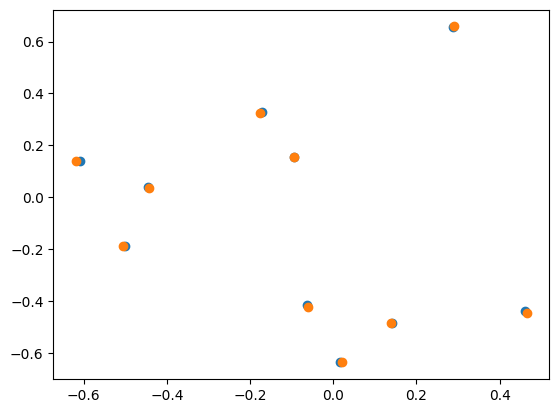

In [9]:
plt.scatter(pts[:,0],pts[:,2])
plt.scatter(x[:,0],x[:,2])




In [10]:
# x = x[x.norm(dim=1).argsort()]
# x


In [11]:
# pts = pts[pts.norm(dim=1).argsort()]
# pts

# Reconstruct Edges

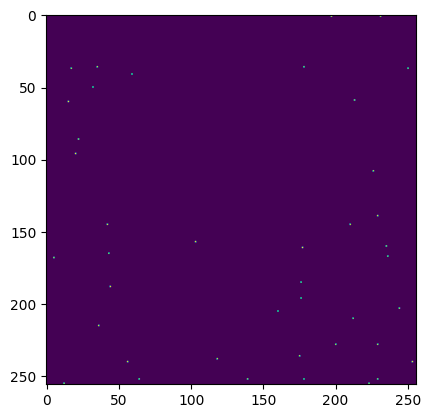

In [12]:
res = minimum_filter(recon_np,footprint=np.ones((11,11,11)))
mask = (recon_np == res)
plt.imshow(mask[:,:,128])

In [13]:
idxx,idxy,idxz = np.nonzero(mask)
vals = recon[idxx,idxy,idxz]
vals /=vals.min()
idx = np.where(vals>.8)

idx_x = idxx[idx]
idx_y = idxy[idx]
idx_z = idxz[idx]

lin = np.linspace(-1,1,NUM_STEPS,endpoint=False)


edge_pts = torch.tensor( np.vstack([lin[idx_x],
lin[idx_y],
lin[idx_z]]).T)

print(vals.sort()[0])


tensor([-2.4176e-03, -3.2823e-04,  1.0139e-03,  ...,  9.4330e-01,
         9.9498e-01,  1.0000e+00])


In [14]:
ei_true = []
for ei_idx in ei.T:
    # print(ei_idx)
    ei_true.append((x[ei_idx[0]]+x[ei_idx[1]])/2)

ei_true = torch.vstack(ei_true)
print(ei_true)
print(edge_pts)

tensor([[ 0.3018, -0.4421, -0.4635],
        [ 0.0383, -0.0412, -0.4510],
        [-0.0766,  0.0550, -0.1519],
        [-0.5310,  0.1193,  0.0881],
        [ 0.3018, -0.4421, -0.4635],
        [-0.0766,  0.0550, -0.1519],
        [ 0.2020, -0.0017, -0.4330],
        [-0.5310,  0.1193,  0.0881],
        [-0.2831,  0.0541, -0.3038],
        [ 0.0383, -0.0412, -0.4510],
        [ 0.2020, -0.0017, -0.4330],
        [-0.2831,  0.0541, -0.3038]])
tensor([[-0.5312,  0.1094,  0.0859],
        [-0.2812,  0.0391, -0.3047],
        [-0.0781,  0.0469, -0.1484],
        [ 0.0391, -0.0547, -0.4453],
        [ 0.2031, -0.0156, -0.4297],
        [ 0.3047, -0.4531, -0.4609]], dtype=torch.float64)


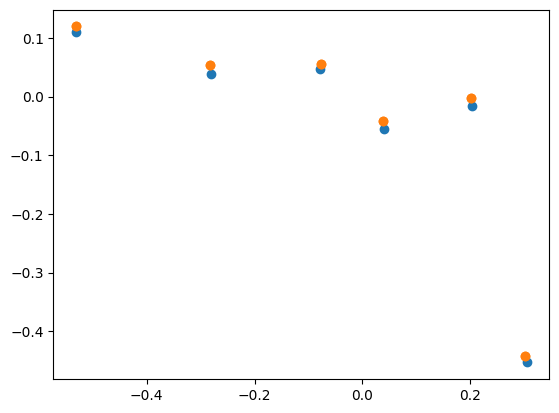

In [15]:
# plt.scatter(pts[:,0],pts[:,1])
plt.scatter(edge_pts[:,0],edge_pts[:,1])
plt.scatter(ei_true[:,0],ei_true[:,1])

In [16]:
print(ei.shape)
print(edge_pts.shape)

torch.Size([2, 12])
torch.Size([6, 3])


In [17]:
adj = np.zeros((len(pts),len(pts)))
ei_recon = []
for i in range(len(pts)):
    for j in range(len(pts)):
        pt_i = pts[i].reshape(1,3)
        pt_j = pts[j].reshape(1,3)
        pt = (pt_i+pt_j )/2
        
        for epts in edge_pts:
            if torch.norm(epts-pt) < .2:
                ei_recon.append([i,j])
        
        # pt.repeat(edge_pts.shape[0],axis=0)-edge_pts
        # print(np.linalg.norm(pt.repeat(edge_pts.shape[0],dim=0)-edge_pts,axis=1).min())
        # if np.linalg.norm(pt.repeat(edge_pts.shape[0],axis=0)-edge_pts,axis=1).min() < .1:
            # print("true")
torch.tensor(ei_recon)

tensor([[0, 1],
        [0, 2],
        [0, 4],
        [0, 7],
        [0, 7],
        [0, 9],
        [1, 0],
        [1, 5],
        [1, 6],
        [2, 0],
        [2, 5],
        [2, 5],
        [2, 6],
        [3, 7],
        [4, 0],
        [4, 5],
        [4, 6],
        [5, 1],
        [5, 2],
        [5, 2],
        [5, 4],
        [5, 7],
        [5, 7],
        [5, 9],
        [5, 9],
        [6, 1],
        [6, 2],
        [6, 4],
        [6, 7],
        [6, 9],
        [7, 0],
        [7, 0],
        [7, 3],
        [7, 5],
        [7, 5],
        [7, 6],
        [7, 7],
        [7, 9],
        [9, 0],
        [9, 5],
        [9, 5],
        [9, 6],
        [9, 7],
        [9, 9]])

In [18]:
pt = np.array([[1,1,0]])
pt2 = np.array([[1,1,1],[1,1,1],[1,1,0]])


